# Support Vector Machine from Scratch
***
## Table of Contents
1. [Loading Data](#1.-loading-data)
2. [Understanding Hyperplanes and Margins](#2-understanding-hyperplanes-and-margins)
3. [Hinge Loss Function](#3-hinge-loss-function)
    - [Hinge Loss Condition](#hinge-loss-condition)
4. [Gradient Descent](#4-gradient-descent-optimisation)
5. [Building a Linear SVM](#5-building-a-linear-svm)
6. [Handling Non-Linear Problems](#6-handling-non-linear-problems)
7. [Kernel Trick](#7-kernel-trick)
8. [Kernel Matrix](#8-kernel-matrix)
9. [Dual Formulation 1 - cvxopt Solver](#9-dual-formulation-1---cvxopt-solver)
    - [Quadratic Programming (QP)](#quadratic-programming-qp)
    - [Decision Function](#decision-function)
10. [Dual Formulation 2 - Sequential Minimal Optimisation (SMO)](#10-dual-formulation-2---sequential-minimal-optimisation-smo)
11. [Model Encapsulation (SMO version)](#11-model-encapsulation-smo-version)
12. [Train Test Split](#12-train-test-split)
13. [Predictions and Model Evaluations](#13-predictions-and-model-evaluations)
14. [Comparing with Scikit-Learn](#14-comparing-with-scikit-learn)
***

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from sklearn.datasets import make_blobs, make_moons, make_circles
from typing import Tuple, Dict
from numpy.typing import NDArray

KernelFunctionType = Callable[[
    NDArray[np.float64], NDArray[np.float64]], float]

Support Vector Machines (SVMs) are versatile supervised machine learning algorithms used to solve classification and regression tasks. The objective of SVMs is to find the best hyperplane (decision boundary) that separates data into different classes and maximises the margin, which is the distance between the hyperplane and the nearest data points from each class (upport ectors). In an 
$n$-dimensional space, the hyperplane is ($n$-1)-dimensional. For example, in 2D space, the hyperplane is a line; in 3D space, it is a plane; and in higher dimensions, it becomes a hyperplane.

There are two types of SVMs:

- **Linear SVM**: Used when the input data is *linearly separable*, meaning the dataset can be divided into two classes with a single straight line.

- **Non-linear SVM**: Used when the input data is *not linearly separable*, meaning the dataset cannot be divided into two classes using a single straight line.

Let's begin by exploring Linear SVM.

## 1. Loading Data

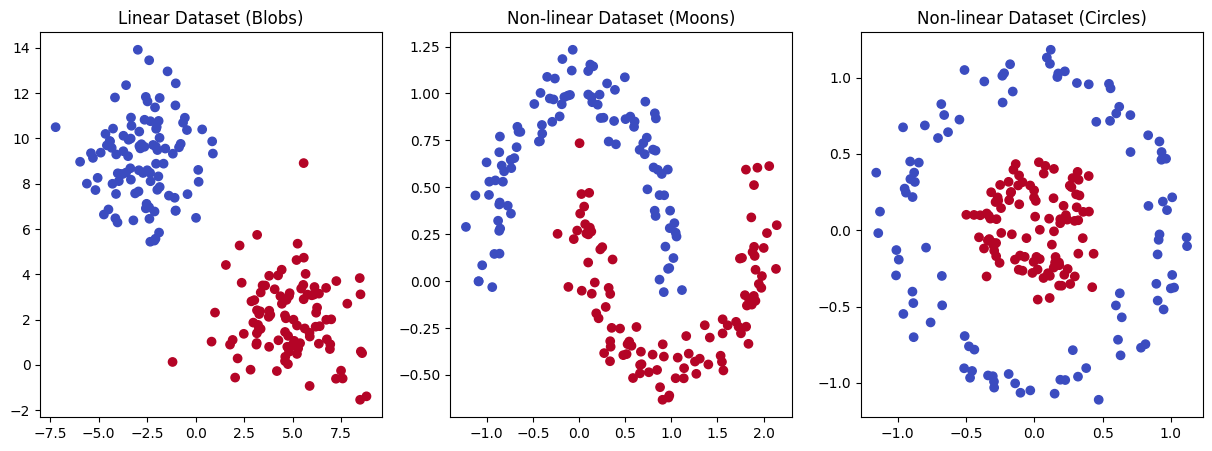

In [2]:
# Linear dataset (make_blobs)
X_linear, y_linear = make_blobs(
    n_samples=200, centers=2, random_state=42, cluster_std=1.8)
y_linear = np.where(y_linear == 0, -1, 1)  # Convert labels to -1, 1

# Non-linear dataset (make_moons)
X_moons, y_moons = make_moons(n_samples=200, noise=0.1, random_state=42)
y_moons = np.where(y_moons == 0, -1, 1)

# Non-linear dataset (make_circles)
X_circles, y_circles = make_circles(
    n_samples=200, factor=0.3, noise=0.1, random_state=42)
y_circles = np.where(y_circles == 0, -1, 1)

# Visualise datasets
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(X_linear[:, 0], X_linear[:, 1], c=y_linear, cmap='coolwarm')
ax[0].set_title("Linear Dataset (Blobs)")

ax[1].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='coolwarm')
ax[1].set_title("Non-linear Dataset (Moons)")

ax[2].scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='coolwarm')
ax[2].set_title("Non-linear Dataset (Circles)")
plt.show()

## 2. Understanding Hyperplanes and Margins
A hyperplane is a subspace of dimension n-1 in an n-dimensional space, which is used as a decision boundary for SVMs. The formula for linear boundary is:

\begin{align*}
w^{T} \cdot x + b = 0
\end{align*}

where:
- $w$: Weight vector.
- $x$: Points in space.
- $b$: Bias (intercept).

For 2D data, the equation expands to:

\begin{align*}
w_{0} \cdot x_{1} + w_{1} \cdot x_{2} + b = 0
\end{align*}

The margin is the width of the *street* between the two classes:
\begin{align*}
M = \dfrac{2}{||w||}
\end{align*}

and
- $w^{T} \cdot x + b = +1$: Positive Margin.
- $w^{T} \cdot x + b = -1$: Negative Margin.

The critical data points that define the decision boundary (the points within the range of margins) are called **support vectors**.

## 3. Hinge Loss Function
Hinge loss function measures the margin violations for a classifier. For a correct classification, the margin should be at least 1. The hinge loss is given by:

\begin{align*}
L = \dfrac{1}{n} \sum^{n}_{i=1}\text{max}(0, 1 - y_{i}(w \cdot x_{i} + b)) + \dfrac{\lambda}{2}||w||^{2}
\end{align*}

where:
- $\lambda = \dfrac{1}{C}$
- $C$: Regularisation parameter
- $w$: Bias
- $b$: Weights

This function penalises samples that fall inside the margin or on the wrong side of the decision boundary while encouraging a larger margin.

### Hinge Loss Condition
For each sample, the loss function verifies a condition (hinge loss condition) to ensure that the SVM maximises the margin street with minimising misclassification errors.

1. If $y_{i}(w \cdot x_{i} + b) \geq 1$: 
- The sample is correctly classified with a margin greater than or equal to 1 (no loss).
- Update only the regularisation term of $w$.

2. If $y_{i}(w \cdot x_{i} + b) < 1$:
- The sample is either misclassified or within the margin (loss occurs).
- Update both $w$ and $b$ to correct for this violation.

In [3]:
def hinge_loss(w: NDArray[np.float64], b: float, X: NDArray[np.float64],
               y: NDArray[np.int64], C: float) -> float:
    """
    Compute the hinge loss for a linear SVM.

    Args:
        w (NDArray[np.float64]): Weight vector of shape (n_features,).
        b (float): Bias term.
        X (NDArray[np.float64]): Feature matrix of shape (n_samples, n_features).
        y (NDArray[np.int64]): Labels of shape (n_samples,) with values in {-1, 1}.
        C (float): Regularisation parameter.

    Returns:
        float: Hinge loss value.
    """
    distances = 1 - y * (np.dot(X, w) + b)  # Calculate distances
    hinge_loss = np.mean(np.maximum(0, distances))  # Mean hinge loss
    regularisation_term = (1 / (2 * C)) * np.sum(w**2)  # Regularisation term
    return hinge_loss + regularisation_term

## 4. Gradient Descent Optimisation
Gradient descent is an optimisation algorithm used to minimise a loss function by iteratively moving towards the local minima while adjusting hyperparameters. In case of SVM, we update the weights $w$ and bias $b$ by calculating gradients of the hinge loss with a learning rate $\alpha$.

1. For $y_{i}(w \cdot x_{i} + b) \geq 1$:

\begin{align*}
\dfrac{\partial L}{\partial w} = w
\end{align*}

\begin{align*}
\dfrac{\partial L}{\partial b} = 0
\end{align*}

2. For $y_{i}(w \cdot x_{i} + b) < 1$:
\begin{align*}
\dfrac{\partial L}{\partial w} = w - Cy_{i}x_{i}
\end{align*}

\begin{align*}
\dfrac{\partial L}{\partial b} = - Cy_{i}
\end{align*}

Then we use these gradients to update $w$ and $b$.

\begin{align*}
w_{\text{new}} = w_{\text{old}} - \alpha (w - Cy_{i}x_{i})
\end{align*}

\begin{align*}
b_{\text{new}} = b_{\text{old}} + \alpha (Cy_{i})
\end{align*}

In [4]:
# Linear SVM Function
def linear_SVM(X: NDArray[np.float64], y: NDArray[np.int64], learning_rate: float = 0.01,
               epochs: int = 1000, C: float = 1.0) -> Tuple[NDArray[np.float64], float]:
    """
    Train a linear SVM using stochastic gradient descent.

    Args:
        X (NDArray[np.float64]): Feature matrix of shape (n_samples, n_features).
        y (NDArray[np.int64]): Labels of shape (n_samples,) with values in {-1, 1}.
        learning_rate (float): Learning rate for gradient updates.
        epochs (int): Number of training epochs.
        C (float): Regularisation parameter.

    Returns:
        Tuple[NDArray[np.float64], float]: Trained weight vector and bias term.
    """

    n_samples, n_features = X.shape
    w = np.zeros(n_features)  # Initialise weights
    b = 0  # Initialise bias

    # Stochastic Gradient Descent
    for epoch in range(epochs):
        for i in range(n_samples):
            # Hinge loss condition
            condition = y[i] * (np.dot(w, X[i]) + b) < 1
            if condition:
                w -= learning_rate * (w - C * y[i] * X[i])
                b += learning_rate * C * y[i]
            else:
                w -= learning_rate * w

        # Calculate loss
        loss = hinge_loss(w, b, X, y, C)
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs} - Loss: {loss:.4f}")
    return w, b


# Accuracy Function
def accuracy(y_true: NDArray[np.int64], y_pred: NDArray[np.int64]) -> float:
    """
    Compute classification accuracy.

    Args:
        y_true (NDArray[np.int64]): True labels.
        y_pred (NDArray[np.int64]): Predicted labels.

    Returns:
        float: Accuracy score.
    """
    return np.mean(y_true == y_pred)


def predict(X: NDArray[np.float64], w: NDArray[np.float64], b: float) -> NDArray[np.int64]:
    """
    Make predictions using the trained linear SVM.

    Args:
        X (NDArray[np.float64]): Feature matrix of shape (n_samples, n_features).
        w (NDArray[np.float64]): Trained weight vector.
        b (float): Trained bias term.

    Returns:
        NDArray[np.int64]: Predicted labels (-1 or 1).
    """
    return np.sign(np.dot(X, w) + b)

## 5. Building a Linear SVM
Now, let's create a function to visualise the decision boundary and margins on our dataset, then merge all the functions into a single class. It requires a rearragement of the hyperplane equations:

\begin{align*}
w_{0} \cdot x_{1} + w_{1} \cdot x_{2} + b = 0 \\
\end{align*}

\begin{align*}
w_{1} \cdot x_{2} = - w_{0} \cdot x_{1} - b \\
\end{align*}

\begin{align*}
x_2 &= -\dfrac{w_0}{w_1} \cdot x_i - \dfrac{b}{w_1} \\
    &= \mathrm{y\_values} = -\dfrac{w_0 \cdot \mathrm{x\_values} + b}{w_1}
\end{align*}



In [5]:
class LinearSVM:
    """
    A linear Support Vector Machine (SVM) classifier using stochastic gradient descent (SGD).
    """

    def __init__(self, learning_rate: float = 0.01, epochs: int = 1000, C: float = 1.0):
        """
        Initialise the LinearSVM model.

        Args:
            learning_rate (float): Learning rate for gradient updates.
            epochs (int): Number of training iterations.
            C (float): Regularisation parameter.
        """
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.C = C
        self.w = None
        self.b: float = 0.0

    def hinge_loss(self, X: NDArray[np.float64], y: NDArray[np.int64]) -> float:
        """
        Compute the hinge loss with L2 regularisation.

        Args:
            X (NDArray[np.float64]): Feature matrix of shape (n_samples, n_features).
            y (NDArray[np.int64]): Labels of shape (n_samples,) with values in {-1, 1}.

        Returns:
            float: Hinge loss value.
        """

    def fit(self, X: NDArray[np.float64], y: NDArray[np.int64]) -> None:
        """
        Train the LinearSVM model using stochastic gradient descent.

        Args:
            X (NDArray[np.float64]): Feature matrix.
            y (NDArray[np.int64]): Labels (-1 or 1).
        """
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)

        # Gradient Descent
        for epoch in range(self.epochs):
            for i in range(n_samples):
                # Hinge Loss Condition
                condition = y[i] * (np.dot(self.w, X[i]) + self.b) < 1
                if condition:
                    self.w -= self.learning_rate * \
                        (self.w - self.C * y[i] * X[i])
                    self.b += self.learning_rate * self.C * y[i]
                else:
                    self.w -= self.learning_rate * self.w

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """
        Predict class labels for input samples.

        Args:
            X (NDArray[np.float64]): Feature matrix.

        Returns:
            NDArray[np.int64]: Predicted labels (-1 or 1).
        """
        return np.sign(np.dot(X, self.w) + self.b)

    def accuracy(self, y_true: NDArray[np.int64], y_pred: NDArray[np.int64]) -> float:
        """
        Calculate the classification accuracy.

        Args:
            y_true (NDArray[np.int64]): True labels.
            y_pred (NDArray[np.int64]): Predicted labels.

        Returns:
            float: Accuracy score.
        """
        return np.mean(y_true == y_pred)

    def plot_decision_boundary(self, X: NDArray[np.float64], y: NDArray[np.int64], ax: plt.Axes,
                               title: str = "Linear SVM Decision Boundary") -> None:
        """
        Plot the decision boundary and margins of the trained SVM.

        Args:
            X (NDArray[np.float64]): Feature matrix.
            y (NDArray[np.int64]): Labels.
            ax (plt.Axes): Matplotlib Axes object for plotting.
            title (str): Title of the plot.
        """
        # Plot all data points
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm',
                   edgecolors='k', label="Data Points")

        # Plot support vectors (inside margins)
        decision_values = y * (np.dot(X, self.w) + self.b)
        within_margin_indices = np.where(
            (decision_values >= -1) & (decision_values <= 1))
        ax.scatter(X[within_margin_indices, 0], X[within_margin_indices, 1],
                   s=100, facecolors='none', edgecolors='orange', label="Support Vectors")

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        x_values = np.linspace(x_min, x_max, 200)

        # Decision boundary
        y_values = -(self.w[0] * x_values + self.b) / self.w[1]

        # Margins
        margin_positive = -(self.w[0] * x_values + self.b - 1) / self.w[1]
        margin_negative = -(self.w[0] * x_values + self.b + 1) / self.w[1]

        ax.plot(x_values, y_values, '-', c='red', label="Decision Boundary")
        ax.plot(x_values, margin_positive, '--', c='grey', label="Margin ±1")
        ax.plot(x_values, margin_negative, '--', c='grey')

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.legend()
        ax.set_title(title)

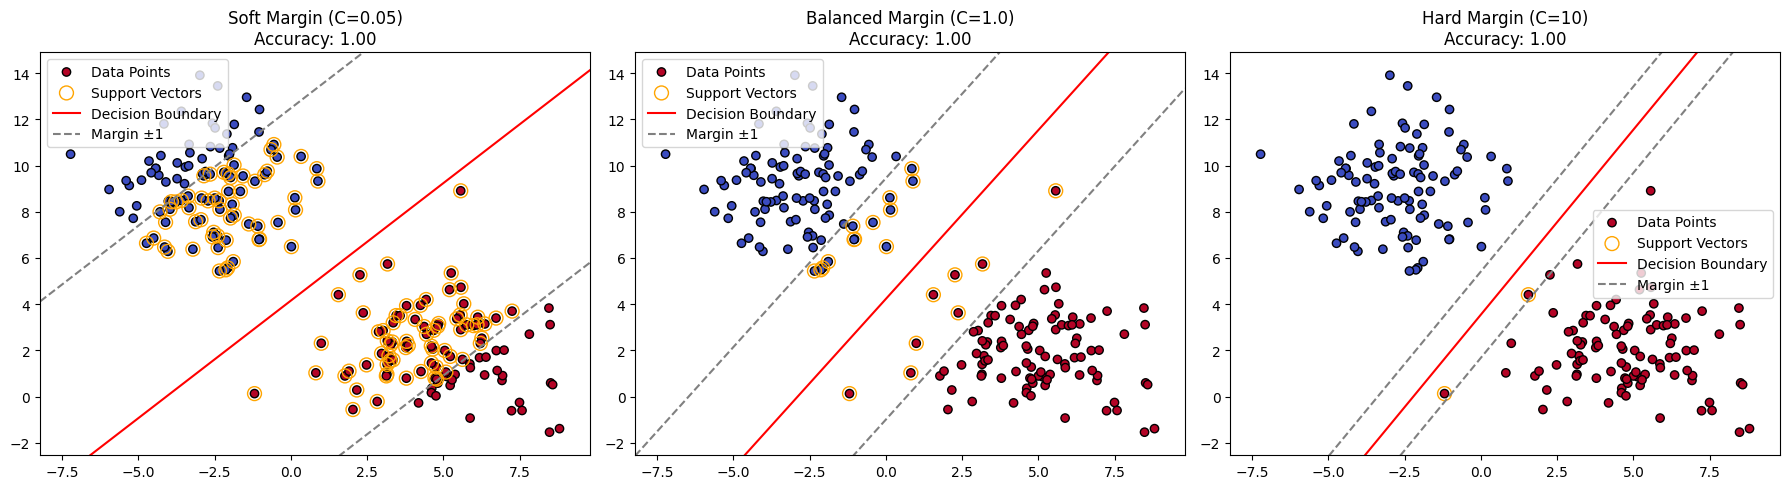

In [6]:
titles = ["Soft Margin (C=0.05)", "Balanced Margin (C=1.0)",
          "Hard Margin (C=10)"]
C_values = [0.05, 1.0, 10]  # Soft, Balanced, Hard margins
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, C in enumerate(C_values):
    svm = LinearSVM(learning_rate=0.01, epochs=1000, C=C)
    svm.fit(X_linear, y_linear)
    y_pred = svm.predict(X_linear)
    acc = svm.accuracy(y_linear, y_pred)
    svm.plot_decision_boundary(X_linear, y_linear, ax=axes[i],
                               title=f"{titles[i]}\nAccuracy: {acc:.2f}")

plt.tight_layout()
plt.show()

Here are three SVM models with different values for the regularisation parameters $C$:
- `C = 0.05`: **Soft margin**, more tolerance for misclassification allowed.
- `C = 1.0`: Balanced case.
- `C = 10.0`: **Hard margin**, almost no misclassification allowed.

## 6. Handling Non-Linear Problems
Previously, we explicitly found a weight vector $w$ and bias $b$, but this approach only works for linear decision boundaries. The dual formulation provides a solution for non-linear problems. Instead of solving for $w$, we solve for Lagrange multipliers $\alpha_{i}$ associated with each training example:

\begin{align*}
\max_{\alpha} \sum_{i=1}^{n} \alpha_{i} - \dfrac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} \alpha_{i} \alpha_{j} y_{i} y_{j} K(x_{i}, x_{j})
\end{align*}

Subject to:
\begin{align*}
\sum_{i=1}^{n} \alpha_{i} y_{i} = 0, \space \space 0 \leq \alpha_{i} \leq C\
\end{align*}

The final decision function becomes:
\begin{align*}
f(x) = \sum_{i=1}^{n} \alpha_{i} y_{i} K(x_{i}, x) + b
\end{align*}

## 7. Kernel Trick
A kernel ($K$) is a function that computes the similarity (or dot product) between two data points in a higher-dimensional feature space, without explicitly performing the mapping to that space. This technique is known as the **kernel trick**. It allows SVMs to perform non-linear classification without paying the computational cost of working in high-dimensional spaces. Common kernel functions are:

| Kernel         | Formula                                  | Captures                                     |
| -------------- | ---------------------------------------- | -------------------------------------------- |
| Linear         | $K(x, x') = x^\top x'$                   | No transformation — basic dot product        |
| Polynomial     | $K(x, x') = (x^\top x' + c)^d$           | Degree-d polynomial relationships            |
| RBF / Gaussian | $K(x, x') = \exp(-\gamma \|x - x'\|^2)$  | Infinite-dimensional features; very flexible |


In [7]:
# Define Kernel Functions
def linear_kernel(x1: NDArray[np.float64], x2: NDArray[np.float64]) -> float:
    """
    Compute the linear kernel between two vectors.

    Args:
        x1 (NDArray[np.float64]): First input vector.
        x2 (NDArray[np.float64]): Second input vector.

    Returns:
        float: Linear kernel result.
    """
    return np.dot(x1, x2)


def polynomial_kernel(x1: NDArray[np.float64], x2: NDArray[np.float64], degree: int = 3,
                      coef0: float = 1.0) -> float:
    """
    Compute the polynomial kernel between two vectors.

    Args:
        x1 (NDArray[np.float64]): First input vector.
        x2 (NDArray[np.float64]): Second input vector.
        degree (int): Degree of the polynomial.
        coef0 (float): Independent term in the polynomial kernel.

    Returns:
        float: Polynomial kernel result.
    """
    return (np.dot(x1, x2) + coef0) ** degree


def rbf_kernel(x1: NDArray[np.float64], x2: NDArray[np.float64], gamma: float = 0.5) -> float:
    """
    Compute the Radial Basis Function (RBF) kernel between two vectors.

    Args:
        x1 (NDArray[np.float64]): First input vector.
        x2 (NDArray[np.float64]): Second input vector.
        gamma (float): RBF kernel coefficient.

    Returns:
        float: RBF kernel result.
    """
    return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

## 8. Kernel Matrix
For dual optimisation, the full Gram matrix $K_{ij} = K(x_i, x_j)$ is required.

In [8]:
# Compute Kernel Matrix
def compute_kernel_matrix(X: NDArray[np.float64],
                          kernel_func: KernelFunctionType) -> NDArray[np.int64]:
    """
    Compute the kernel matrix for the dataset using a given kernel function.

    Args:
        X (NDArray[np.float64]): Feature matrix of shape (n_samples, n_features).
        kernel_func (KernelFunctionType): Kernel function to apply.

    Returns:
        NDArray[np.int64]: Kernel matrix of shape (n_samples, n_samples).
    """
    n_samples = X.shape[0]
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel_func(X[i], X[j])
    return K

## 9. Dual Formulation 1 - cvxopt Solver

To implement dual formulation, we can either:
- Use `cvxopt` library to solve the quadratic programming problem, or
- Implement **Sequential Minimal Optimisation (SMO)**, which is more efficient and scalable.

Let's start with the `cvxopt` version.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

### Quadratic Programming (QP)
This is a Quadratic Programming problem of the form:
\begin{align*}
\min_{\alpha} \dfrac{1}{2} \alpha^{T}P \alpha + q^{T} \alpha
\end{align*}
Subject to: $G \alpha \leq h$, $A\alpha = b$

- Compute $K_{ij} = K(x_i, x_j)$, the kernel matrix
- $P = yy^T \odot K$, element-wise multiplication: $P_{ij} = y_i y_j K(x_i, x_j)$
- $q = -1$
- `G_slack`, `h_slack` -> Encodes $\alpha_i \leq C$
- `G`, `h` -> Stack both constraints into:
\begin{align*}
\begin{bmatrix}
-I\\
I 
\end{bmatrix}
\alpha \leq 
\begin{bmatrix}
0\\
C 
\end{bmatrix}
\end{align*}

- `A`, `b` -> Equality constraints: $\sum_{i=1}^{n} \alpha_i y_i$

In [10]:
def train_svm_dual(X: NDArray[np.float64], y: NDArray[np.int64], C: float = 1.0,
                   kernel: KernelFunctionType = linear_kernel
                   ) -> Tuple[NDArray[np.float64], NDArray[np.float64], NDArray[np.float64], float, KernelFunctionType]:
    """
    Train a kernel SVM using the dual form and quadratic programming.

    Args:
        X (NDArray[np.float64]): Feature matrix.
        y (NDArray[np.int64]): Labels (-1 or 1).
        C (float): Regularisation parameter.
        kernel (Callable[[NDArray[np.float64], NDArray[np.float64]], float]): Kernel function.

    Returns:
        Tuple: (alphas, support vectors, support labels, bias, kernel used)
    """
    n_samples = X.shape[0]
    K = compute_kernel_matrix(X, kernel)

    # Construct QP matrices
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(n_samples))
    G_std = matrix(np.diag(-np.ones(n_samples)))  # -alpha ≤ 0
    h_std = matrix(np.zeros(n_samples))
    G_slack = matrix(np.diag(np.ones(n_samples)))  # alpha ≤ C
    h_slack = matrix(np.ones(n_samples) * C)
    G = matrix(np.vstack((G_std, G_slack)))
    h = matrix(np.vstack((h_std, h_slack)))
    A = matrix(y.reshape(1, -1).astype(np.double))
    b = matrix(np.zeros(1))

    # Solve QP problem
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(solution['x'])

    # Support vectors have non-zero alpha
    sv = alphas > 1e-5
    alpha_sv = alphas[sv]
    X_sv = X[sv]
    y_sv = y[sv]

    # Compute bias term (use K with support vectors)
    b = 0
    b_values = [y_sv[i] - np.sum(alpha_sv * y_sv * K[sv][:, sv][i])
                for i in range(len(alpha_sv))]
    b = np.mean(b_values)

    return alpha_sv, X_sv, y_sv, b, kernel

### Decision Function
The decision functions for different kernels:

\begin{align*}
f(x) = \sum_{i=1}^{n} \alpha_{i} y_{i} K(x_{i}, x) + b
\end{align*}


In [11]:
def decision_function(X_test: NDArray[np.float64], alpha_sv: NDArray[np.float64],
                      X_sv: NDArray[np.float64], y_sv: NDArray[np.int64], b: float,
                      kernel: KernelFunctionType) -> NDArray[np.float64]:
    """
    Compute the decision function values for the given test samples.

    Args:
        X_test (NDArray[np.float64]): Test samples.
        alpha_sv (NDArray[np.float64]): Alpha values of support vectors.
        X_sv (NDArray[np.float64]): Support vectors.
        y_sv (NDArray[np.int64]): Support vector labels.
        b (float): Bias term.
        kernel (KernelFunctionType): Kernel function.

    Returns:
        np.ndarray: Decision values.
    """
    f_x = []
    for x in X_test:
        result = 0
        for alpha, sv_y, sv_x in zip(alpha_sv, y_sv, X_sv):
            result += alpha * sv_y * kernel(x, sv_x)
        f_x.append(result + b)
    return np.array(f_x)


def predict_svm(X_test: NDArray[np.float64], alpha_sv: NDArray[np.float64],
                X_sv: NDArray[np.float64], y_sv: NDArray[np.int64], b: float,
                kernel: KernelFunctionType) -> NDArray[np.float64]:
    """
    Predict class labels for test samples using the trained dual SVM.

    Args:
        X_test (NDArray[np.float64]): Test feature matrix.
        alpha_sv (NDArray[np.float64]): Alpha values.
        X_sv (NDArray[np.float64]): Support vectors.
        y_sv (NDArray[np.int64]): Support labels.
        b (float): Bias term.
        kernel (KernelFunctionType): Kernel function.

    Returns:
        np.ndarray: Predicted class labels (-1 or 1).
    """
    return np.sign(decision_function(X_test, alpha_sv, X_sv, y_sv, b, kernel))

In [12]:
def plot_all_kernels(X: NDArray[np.float64], y: NDArray[np.int64],
                     kernel_dict: Dict[str, KernelFunctionType],
                     title_prefix: str = "Dataset") -> None:
    """
    Plot decision boundaries for different kernels.

    Args:
        X (NDArray[np.float64]): Feature matrix.
        y (NDArray[np.int64]): Labels.
        kernel_dict (Dict[str, KernelFunctionType]): Dictionary mapping kernel names to functions.
        title_prefix (str): Prefix for subplot titles.
    """
    plt.figure(figsize=(16, 6))
    for i, (kernel_name, kernel_func) in enumerate(kernel_dict.items()):
        alpha_sv, X_sv, y_sv, b, kernel_used = train_svm_dual(
            X, y, C=1.0, kernel=kernel_func)

        # Predict and compute accuracy
        y_pred = predict_svm(X, alpha_sv, X_sv, y_sv, b, kernel_used)
        accuracy = np.mean(y_pred == y)

        # Create grid
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                             np.linspace(y_min, y_max, 300))
        grid = np.c_[xx.ravel(), yy.ravel()]
        Z = decision_function(grid, alpha_sv, X_sv, y_sv,
                              b, kernel_used).reshape(xx.shape)

        ax = plt.subplot(1, 3, i + 1)
        contour = ax.contour(xx, yy, Z, levels=[-1, 0, 1],
                             colors=['grey', 'red', 'grey'],
                             linestyles=['--', '-', '--'])

        # Add labels to contours
        fmt = {level: label for level, label in zip(
            [-1, 0, 1], ['Margin -1', 'Decision Boundary', 'Margin +1'])}
        ax.clabel(contour, inline=True, fontsize=9, fmt=fmt)

        # Plot data
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', s=40)

        # Plot support vectors (decision values inside the margins)
        decision_values = decision_function(
            X_sv, alpha_sv, X_sv, y_sv, b, kernel_used)

        within_margin_indices = np.where(
            (decision_values >= -1) & (decision_values <= 1))
        margin_sv = X_sv[within_margin_indices]
        ax.scatter(margin_sv[:, 0], margin_sv[:, 1], s=100, facecolors='none',
                   edgecolors='orange', label='Support Vectors')

        ax.set_title(
            f"{title_prefix} - {kernel_name} Kernel\nAccuracy: {accuracy:.2%}")
        ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

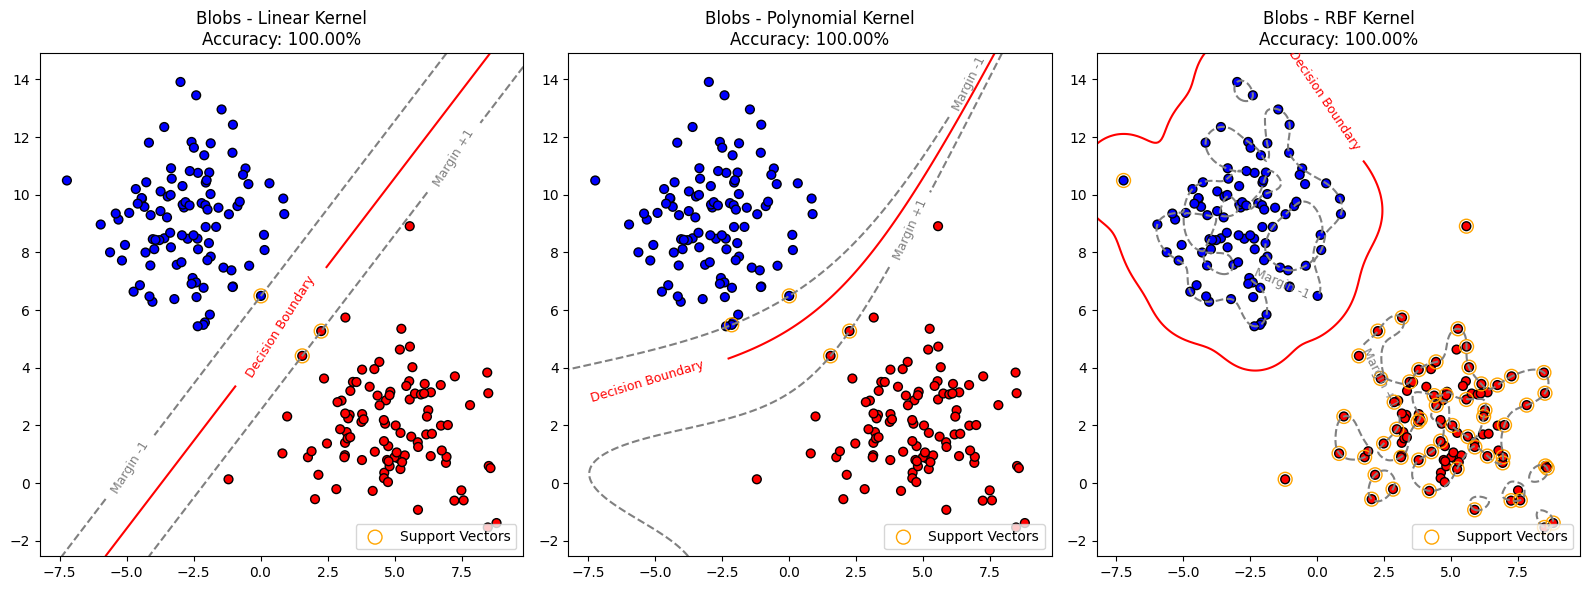

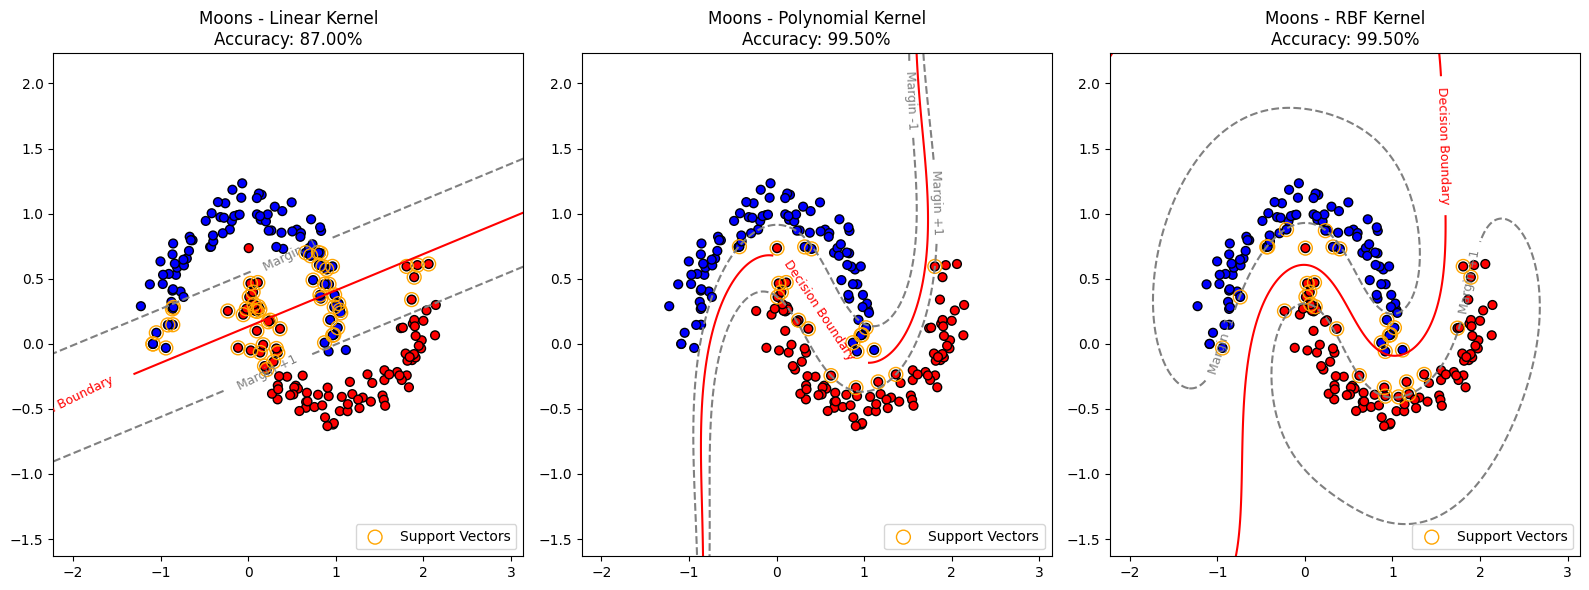

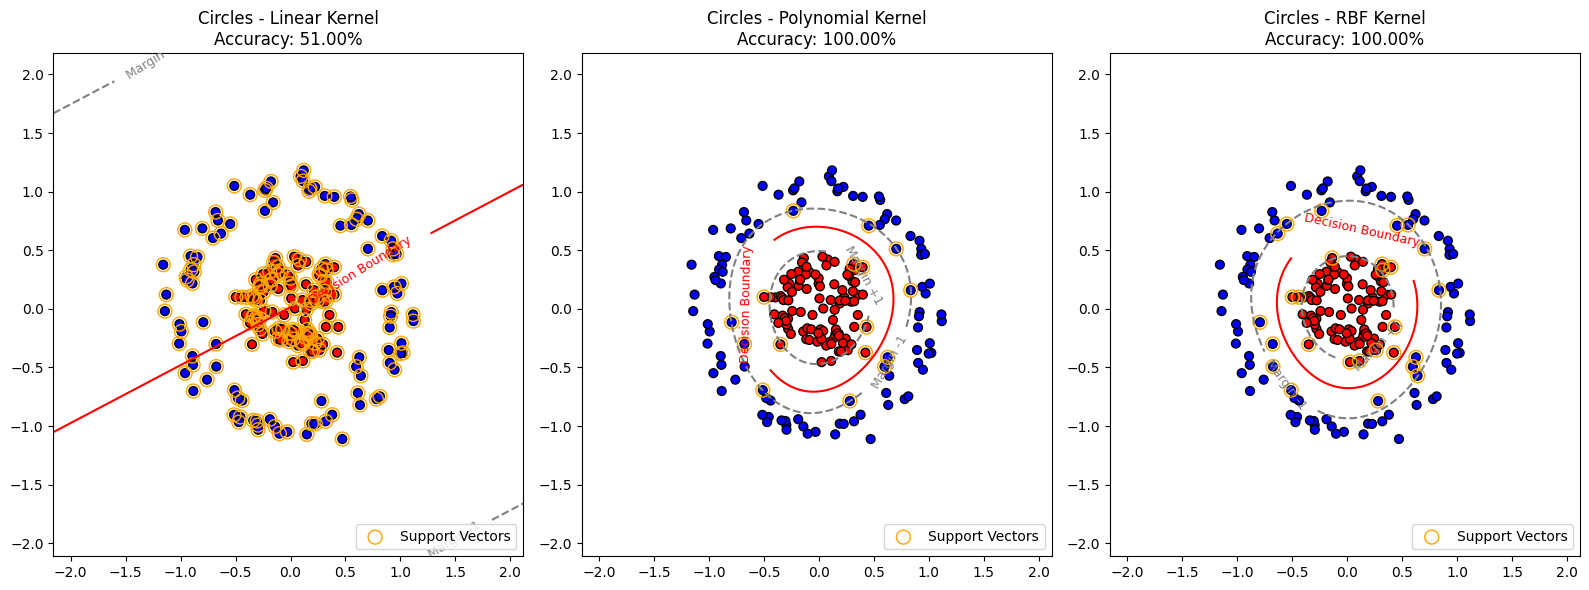

In [13]:
kernel_dict = {
    'Linear': lambda x, y: linear_kernel(x, y),
    'Polynomial': lambda x, y: polynomial_kernel(x, y, degree=3, coef0=1),
    'RBF': lambda x, y: rbf_kernel(x, y, gamma=1.0),
}

# Plot for each dataset
plot_all_kernels(X_linear, y_linear, kernel_dict, title_prefix="Blobs")
plot_all_kernels(X_moons, y_moons, kernel_dict, title_prefix="Moons")
plot_all_kernels(X_circles, y_circles, kernel_dict, title_prefix="Circles")

## 10. Dual Formulation 2 - Sequential Minimal Optimisation (SMO)
SMO is an efficient method for solving the SVM dual problem by breaking it into smaller sub-problems that can be solved analytically - typically optimising **two Lagrange multiplieres** at a time.

Steps:
1. Initialise all Lagrange Multipliers `alphas` and bias `b` to 0.
2. Loop through all training samples (heuristic selection of pairs for efficiency).
3. For each pair (`i`, `j`):
    - Compute the error for each sample (`Ei`, `Ej`).
    - Check if KKT conditions are violated.
    - If so, compute bounds `L` and `H` for `alpha_j`.
    - Compute second derivative `eta`.
    - Update `alpha_j` and clip it with bounds.
    - Update `alpha_i` accordingly.
    - Compute the new bias `b`.
4. Repeat the process until convergence or max number of passes without changes.

In [14]:
# Kernel matrix using list comprehension and broadcasting
def compute_kernel_matrix(X: NDArray[np.float64],
                          kernel_func: KernelFunctionType) -> NDArray[np.int64]:
    """
    Compute the kernel matrix for a dataset using a given kernel function.

    Parameters:
        X (NDArray[np.float64]): Input dataset of shape (n_samples, n_features).
        kernel_func (KernelFunctionType): Kernel function to compute similarities.

    Returns:
        NDArray[np.int64]: Kernel matrix of shape (n_samples, n_samples).
    """
    return np.array([[kernel_func(x1, x2) for x2 in X] for x1 in X])


def compute_error(i: int, alphas: NDArray[np.float64], y: NDArray[np.int64],
                  K: NDArray[np.int64], b: float) -> float:
    """
    Compute the prediction error for a sample.

    Parameters:
        i (int): Index of the sample.
        alphas (NDArray[np.float64]): Array of Lagrange multipliers.
        y (NDArray[np.int64]): Target labels.
        K (NDArray[np.int64]): Kernel matrix.
        b (float): Bias term.

    Returns:
        float: Prediction error for the ith sample.
    """
    return np.dot(alphas * y, K[:, i]) + b - y[i]


def compute_bounds(y_i: int, y_j: int, alpha_i: float, alpha_j: float,
                   C: float) -> Tuple[float, float]:
    """
    Compute the bounds for Lagrange multipliers during optimisation.

    Parameters:
        y_i (int): Label of the ith sample.
        y_j (int): Label of the jth sample.
        alpha_i (float): Current value of alpha for the i-th sample.
        alpha_j (float): Current value of alpha for the j-th sample.
        C (float): Regularisation parameter.

    Returns:
        Tuple[float, float]: Lower and upper bounds for alpha_j.
    """
    if y_i != y_j:
        return max(0, alpha_j - alpha_i), min(C, C + alpha_j - alpha_i)
    else:
        return max(0, alpha_i + alpha_j - C), min(C, alpha_i + alpha_j)


def update_bias(b: float, Ei: float, Ej: float, y_i: int, y_j: int,
                alpha_i: float, alpha_j: float, alpha_i_old: float,
                alpha_j_old: float, K: NDArray[np.int64], i: int, j: int,
                C: float) -> float:
    """
    Update the bias term during the SMO optimisation process.

    Parameters:
        b (float): Current bias term.
        Ei (float): Error for the ith sample.
        Ej (float): Error for the jth sample.
        y_i (int): Label of the ith sample.
        y_j (int): Label of the jth sample.
        alpha_i (float): Updated alpha for the ith sample.
        alpha_j (float): Updated alpha for the jth sample.
        alpha_i_old (float): Previous alpha for the ith sample.
        alpha_j_old (float): Previous alpha for the jth sample.
        K (NDArray[np.int64]): Kernel matrix.
        i (int): Index of the ith sample.
        j (int): Index of the jth sample.
        C (float): Regularisation parameter.

    Returns:
        float: Updated bias term.
    """
    b1 = b - Ei - y_i * (alpha_i - alpha_i_old) * \
        K[i, i] - y_j * (alpha_j - alpha_j_old) * K[i, j]
    b2 = b - Ej - y_i * (alpha_i - alpha_i_old) * \
        K[i, j] - y_j * (alpha_j - alpha_j_old) * K[j, j]
    if 0 < alpha_i < C:
        return b1
    elif 0 < alpha_j < C:
        return b2
    return (b1 + b2) / 2


def smo_train(X: NDArray[np.float64], y: NDArray[np.int64], kernel_func: KernelFunctionType,
              C: float = 1.0, tol: float = 1e-3, max_passes: int = 10) -> Tuple[NDArray[np.float64], NDArray[np.float64],
                                                                                NDArray[np.float64], float, KernelFunctionType]:
    """
    Train a Support Vector Machine using the Sequential Minimal Optimisation (SMO) algorithm.

    Parameters:
        X (NDArray[np.float64]): Input dataset of shape (n_samples, n_features).
        y (NDArray[np.int64]): Target labels of shape (n_samples,).
        kernel_func (KernelFunctionType): Kernel function to compute similarities.
        C (float): Regularisation parameter. Default is 1.0.
        tol (float): Tolerance for stopping criterion. Default is 1e-3.
        max_passes (int): Maximum number of iterations without changes. Default is 10.

    Returns:
        tuple: Support vectors, corresponding alphas, labels, bias term, and the kernel function.
    """
    n_samples = len(y)
    alphas = np.zeros(n_samples)
    b = 0
    passes = 0

    # Kernel matrix (for pairwise kernel evaluations)
    K = compute_kernel_matrix(X, kernel_func)

    # Optimisation loop until convergence or max_passes is reached
    while passes < max_passes:
        # Track the number of alphas updated in this pass
        alpha_changed = 0

        # Iterate over each sample
        for i in range(n_samples):
            # Compute the error for the current sample
            Ei = compute_error(i, alphas, y, K, b)

            # Check if the sample violated the KKT conditions
            if (y[i] * Ei < -tol and alphas[i] < C) or (y[i] * Ei > tol and alphas[i] > 0):
                # Randomly select a second sample (j) different from i
                j = np.random.choice([x for x in range(n_samples) if x != i])

                # Compute the error for the second sample
                Ej = compute_error(j, alphas, y, K, b)

                # Store the old values of alphas for i and j
                alpha_i_old, alpha_j_old = alphas[i], alphas[j]

                # Compute the bounds L and H for the new value of alpha_j
                L, H = compute_bounds(y[i], y[j], alpha_i_old, alpha_j_old, C)
                if L == H:
                    # If bounds are the same, skip this pair
                    continue

                # Compute the second derivative (eta) of the objective function
                eta = 2 * K[i, j] - K[i, i] - K[j, j]
                if eta >= 0:
                    # If eta is non-negative, skip this pair as it won't reduce the objective
                    continue

                # Update alpha_j using the gradient of the objective function
                alphas[j] -= y[j] * (Ei - Ej) / eta

                # Clip alpha_j to ensure it lies within the bounds [L, H]
                alphas[j] = np.clip(alphas[j], L, H)

                # Check if the change in alpha_j is significant
                # if abs(alphas[j] - alpha_j_old) < 1e-12:
                #     continue

                # Update alpha_i based on the new value of alpha_j
                alphas[i] += y[i] * y[j] * (alpha_j_old - alphas[j])

                # Update the bias term to ensure the KKT conditions are satisfied
                b = update_bias(
                    b, Ei, Ej, y[i], y[j], alphas[i], alphas[j], alpha_i_old, alpha_j_old, K, i, j, C)

                # +1 to the count of alpha updates
                alpha_changed += 1

        # If no alphas were updated in this pass, increment passes
        passes += 1 if alpha_changed == 0 else 0

    # Identify support vectors (non-zero alphas)
    sv_mask = alphas > 1e-5
    return alphas[sv_mask], X[sv_mask], y[sv_mask], b, kernel_func


def smo_decision_function(X_test: NDArray[np.float64], alpha_sv: NDArray[np.float64],
                          X_sv: NDArray[np.float64], y_sv: NDArray[np.int64],
                          b: float, kernel_func: KernelFunctionType) -> np.ndarray:
    """
    Compute the decision function for a test dataset using support vectors.

    Parameters:
        X_test (NDArray[np.float64]): Test dataset of shape (n_test_samples, n_features).
        alpha_sv (NDArray[np.float64]): Support vector Lagrange multipliers.
        X_sv (NDArray[np.float64]): Support vectors of shape (n_sv, n_features).
        y_sv (NDArray[np.int64]): Labels of the support vectors.
        b (float): Bias term.
        kernel_func (KernelFunctionType): Kernel function used in training.

    Returns:
        np.ndarray: Decision values for the test samples.
    """
    return np.array([
        sum(alpha * y * kernel_func(x, sv)
            for alpha, y, sv in zip(alpha_sv, y_sv, X_sv)) + b
        for x in X_test
    ])


def smo_predict(X_test: NDArray[np.float64], alpha_sv: NDArray[np.float64],
                X_sv: NDArray[np.float64], y_sv: NDArray[np.int64],
                b: float, kernel_func: KernelFunctionType) -> NDArray[np.float64]:
    """
    Make predictions for a test dataset using a trained SVM.

    Parameters:
        X_test (NDArray[np.float64]): Test dataset of shape (n_test_samples, n_features).
        alpha_sv (NDArray[np.float64]): Support vector Lagrange multipliers.
        X_sv (NDArray[np.float64]): Support vectors of shape (n_sv, n_features).
        y_sv (NDArray[np.int64]): Labels of the support vectors.
        b (float): Bias term.
        kernel_func (KernelFunctionType): Kernel function used in training.

    Returns:
        np.ndarray: Predicted labels for the test samples.
    """
    return np.sign(smo_decision_function(X_test, alpha_sv, X_sv, y_sv, b, kernel_func))


def plot_all_kernels_smo(X: NDArray[np.float64], y: NDArray[np.int64], kernel_dict: Dict[str, KernelFunctionType],
                         title_prefix: str = "Dataset") -> None:
    """
    Visualise decision boundaries for different kernels using a trained SVM.

    Parameters:
        X (NDArray[np.float64]): Input dataset of shape (n_samples, n_features).
        y (NDArray[np.int64]): Target labels of shape (n_samples,).
        kernel_dict (Dict[str, KernelFunctionType]): Dictionary of kernel names and corresponding functions.
        title_prefix (str): Prefix for subplot titles. Default is "Dataset".

    Returns:
        None
    """
    plt.figure(figsize=(16, 6))
    for i, (kernel_name, kernel_func) in enumerate(kernel_dict.items()):
        alpha_sv, X_sv, y_sv, b, kernel_used = smo_train(
            X, y, kernel_func=kernel_func, C=1.0)

        y_pred = smo_predict(X, alpha_sv, X_sv, y_sv, b, kernel_used)
        accuracy = np.mean(y_pred == y)

        # Create mesh grid
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                             np.linspace(y_min, y_max, 300))
        grid = np.c_[xx.ravel(), yy.ravel()]
        Z = smo_decision_function(
            grid, alpha_sv, X_sv, y_sv, b, kernel_used).reshape(xx.shape)

        ax = plt.subplot(1, 3, i + 1)
        contour = ax.contour(
            xx, yy, Z, levels=[-1, 0, 1], colors=['grey', 'red', 'grey'], linestyles=['--', '-', '--'])
        fmt = {-1: "Margin -1", 0: "Decision Boundary", 1: "Margin +1"}
        ax.clabel(contour, inline=True, fontsize=9, fmt=fmt)
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', s=40)

        # Plot support vectors (decision values inside the margins)
        decision_values = smo_decision_function(
            X_sv, alpha_sv, X_sv, y_sv, b, kernel_used)

        within_margin_indices = np.where(
            (decision_values >= -1) & (decision_values <= 1))
        margin_sv = X_sv[within_margin_indices]
        ax.scatter(margin_sv[:, 0], margin_sv[:, 1], s=100, facecolors='none',
                   edgecolors='orange', label='Support Vectors')

        ax.set_title(
            f"{title_prefix} - {kernel_name} Kernel\nAccuracy: {accuracy:.2%}")
        ax.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

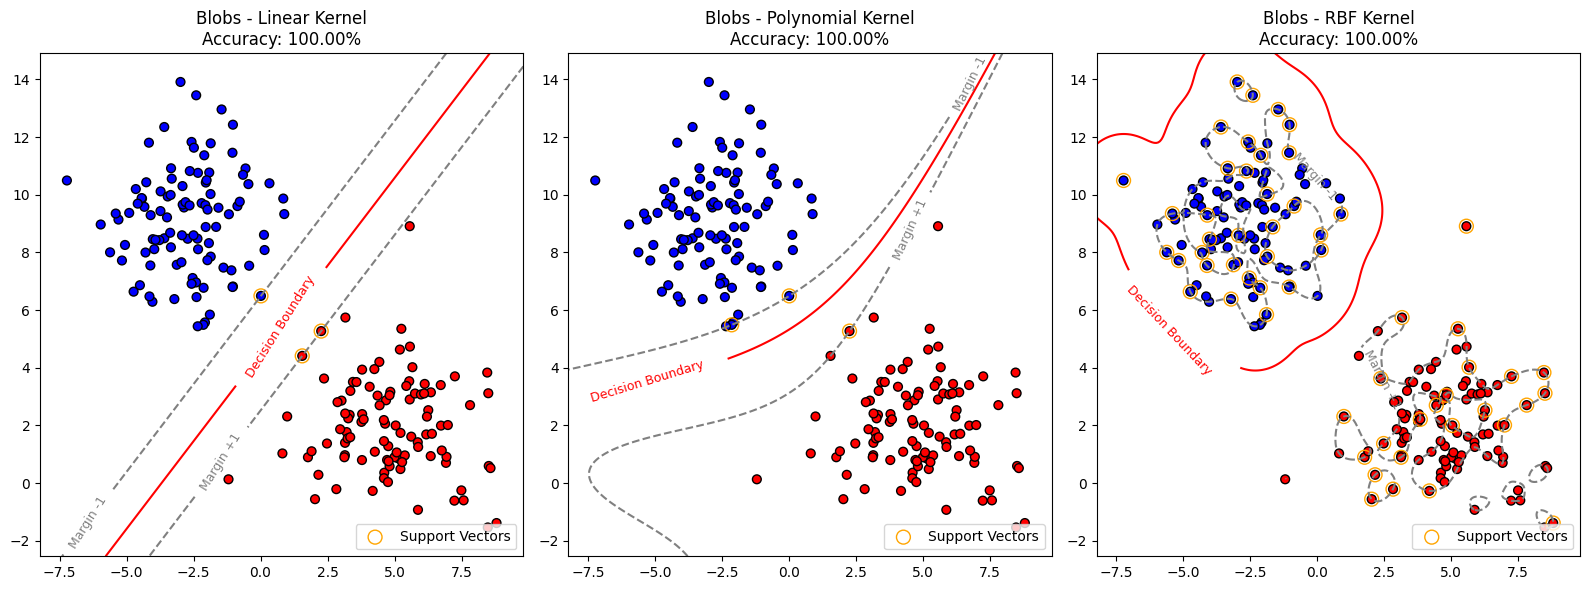

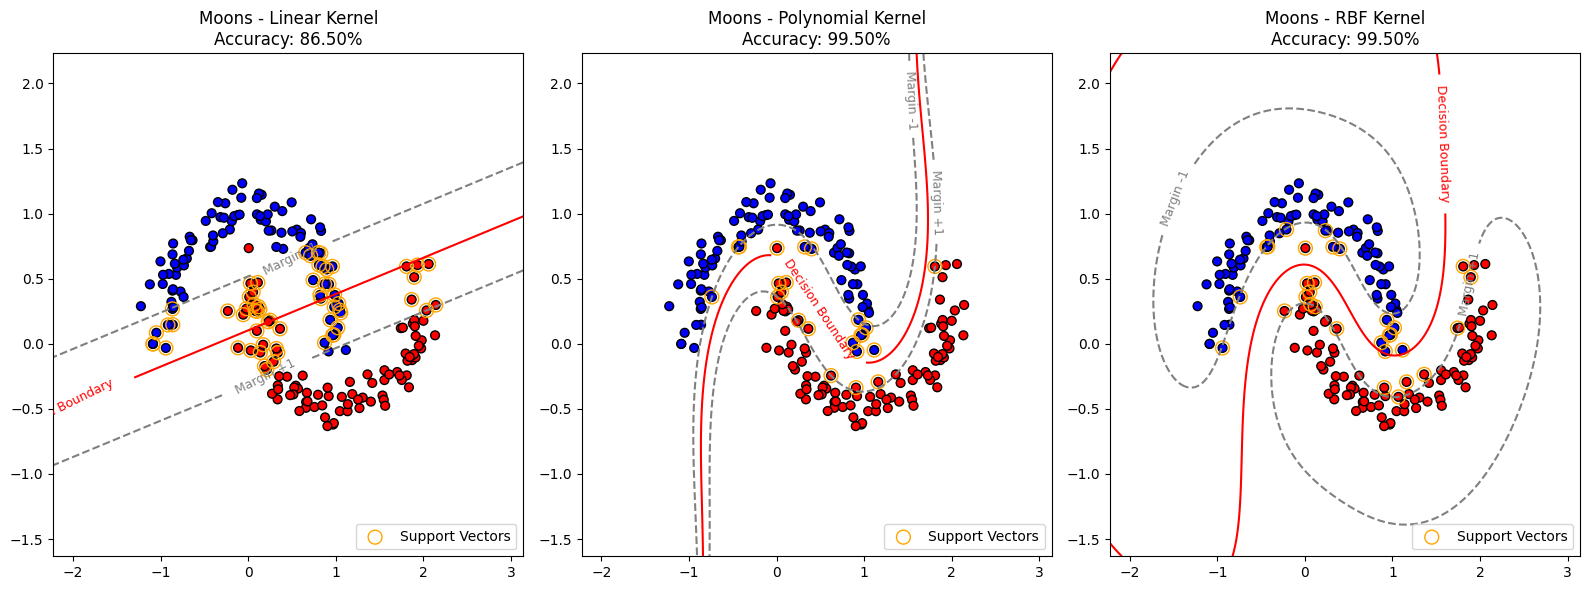

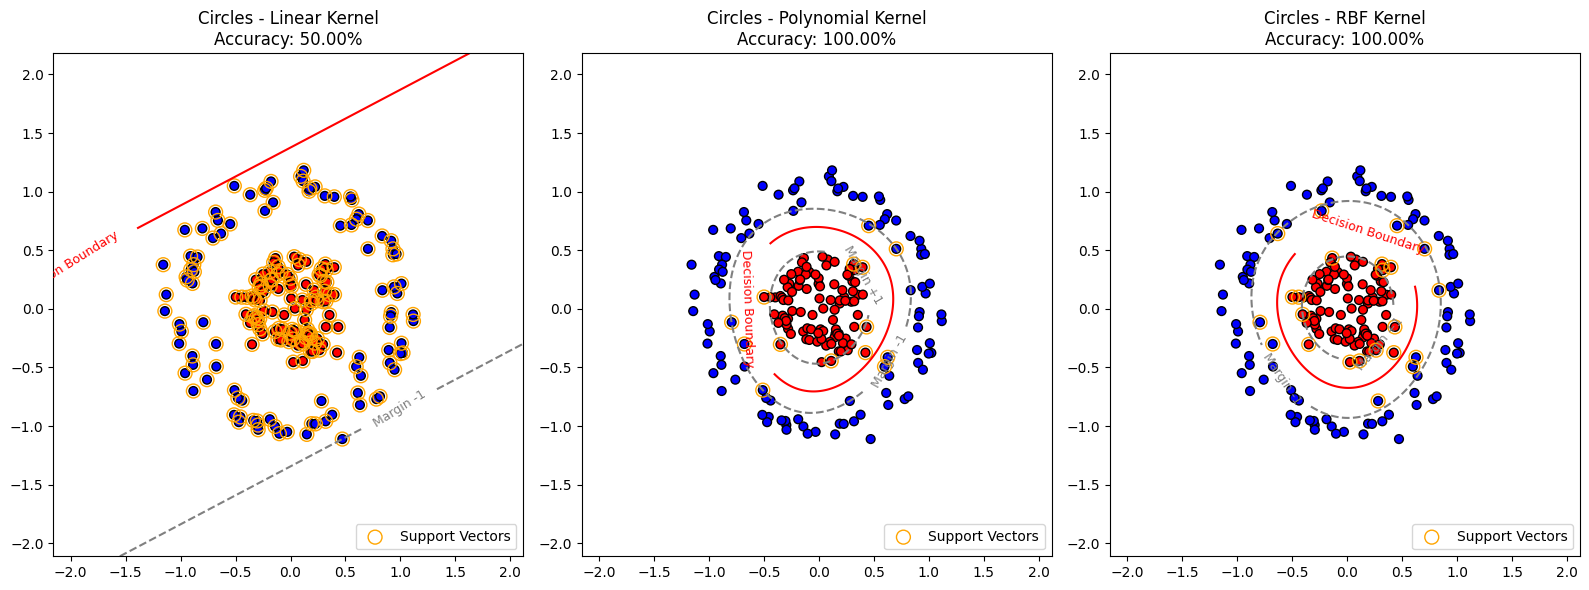

In [15]:
kernel_dict = {
    'Linear': lambda x, y: linear_kernel(x, y),
    'Polynomial': lambda x, y: polynomial_kernel(x, y, degree=3, coef0=1),
    'RBF': lambda x, y: rbf_kernel(x, y, gamma=1.0),
}

plot_all_kernels_smo(X_linear, y_linear, kernel_dict, title_prefix="Blobs")
plot_all_kernels_smo(X_moons, y_moons, kernel_dict, title_prefix="Moons")
plot_all_kernels_smo(X_circles, y_circles, kernel_dict, title_prefix="Circles")

## 11. Model Encapsulation (SMO version)

In [16]:
class CustomSVM:
    """
    A custom implementation of a Support Vector Machine (SVM) using Sequential Minimal Optimisation (SMO).

    Attributes:
        kernel_name (str): Name of the kernel function.
        kernel_func (KernelFunctionType): Kernel function.
        C (float): Regularisation parameter.
        tol (float): Tolerance for stopping criterion.
        max_passes (int): Maximum number of iterations without alpha updates.
        degree (int): Degree for polynomial kernel.
        coef0 (float): Independent term in polynomial and sigmoid kernels.
        gamma (float): Parameter for RBF, polynomial, and sigmoid kernels.
        sv_threshold (float): Threshold to identify support vectors.
        alpha_diff_threshold (float): Minimum change in alpha to be considered significant.
        alpha_sv (NDArray[np.float64]): Support vector Lagrange multipliers.
        X_sv (NDArray[np.float64]): Support vectors.
        y_sv (NDArray[np.int64]): Labels of the support vectors.
        b (float): Bias term.
        weighted_sv (NDArray[np.float64]): Precomputed product of alpha_sv and y_sv for efficiency.
    """

    def __init__(self, kernel: str = "linear", C: float = 1.0, tol: float = 1e-3,
                 max_passes: int = 10, degree: int = 3, coef0: float = 1.0,
                 gamma: float = 0.5, sv_threshold: float = 1e-8,
                 alpha_diff_threshold: float = 1e-8):
        """
        Initialise the SVM model with the given hyperparameters.

        Parameters:
            kernel (str): Kernel function to use ("linear", "poly", or "rbf").
            C (float): Regularisation parameter.
            tol (float): Tolerance for stopping criterion.
            max_passes (int): Maximum number of iterations without alpha updates.
            degree (int): Degree for polynomial kernel.
            coef0 (float): Independent term in polynomial kernel.
            gamma (float): Parameter for RBF kernel.
            sv_threshold (float): Threshold to identify support vectors.
            alpha_diff_threshold (float): Minimum change in alpha to be considered significant.
        """
        self.C = C
        self.tol = tol
        self.max_passes = max_passes
        self.degree = degree
        self.coef0 = coef0
        self.gamma = gamma
        self.sv_threshold = sv_threshold
        self.alpha_diff_threshold = alpha_diff_threshold
        self.kernel_name = kernel
        self.kernel_func: KernelFunctionType = self.get_kernel_func(kernel)

        # Learned parameters
        self.alpha_sv = None
        self.X_sv = None
        self.y_sv = None
        self.b = 0
        self.weighted_sv = None  # Precomputed product for efficiency

    def get_kernel_func(self, kernel: str) -> KernelFunctionType:
        """
        Retrieve the kernel function based on the kernel name.

        Parameters:
            kernel (str): Name of the kernel.

        Returns:
            KernelFunctionType: Kernel function.
        """
        if kernel == "linear":
            return lambda x1, x2: np.dot(x1, x2)
        elif kernel == "poly":
            return lambda x1, x2: (np.dot(x1, x2) + self.coef0) ** self.degree
        elif kernel == "rbf":
            return lambda x1, x2: np.exp(-self.gamma * np.linalg.norm(x1 - x2) ** 2)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

    def compute_kernel_matrix(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """
        Compute the kernel matrix for the dataset.

        Parameters:
            X (NDArray[np.float64]): Input dataset of shape (n_samples, n_features).

        Returns:
            NDArray[np.int64]: Kernel matrix.
        """
        return np.array([[self.kernel_func(x1, x2) for x2 in X] for x1 in X])

    def error(self, i: int, alphas: NDArray[np.float64], y: NDArray[np.int64],
              K: NDArray[np.int64], b: float) -> float:
        """
        Compute the error for the i-th sample.

        Parameters:
            i (int): Index of the sample.
            alphas (NDArray[np.float64]): Lagrange multipliers.
            y (NDArray[np.int64]): Labels.
            K (NDArray[np.int64]): Kernel matrix.
            b (float): Bias term.

        Returns:
            float: Error for the i-th sample.
        """
        return np.dot(alphas * y, K[:, i]) + b - y[i]

    def bounds(self, y_i: int, y_j: int, alpha_i: float, alpha_j: float) -> Tuple[float, float]:
        """
        Compute the bounds for alpha_j during optimisation.

        Parameters:
            y_i (int): Label for sample i.
            y_j (int): Label for sample j.
            alpha_i (float): Current alpha for sample i.
            alpha_j (float): Current alpha for sample j.

        Returns:
            Tuple[float, float]: Lower and upper bounds for alpha_j.
        """
        if y_i != y_j:
            return max(0, alpha_j - alpha_i), min(self.C, self.C + alpha_j - alpha_i)
        return max(0, alpha_i + alpha_j - self.C), min(self.C, alpha_i + alpha_j)

    def update_bias(self, b: float, Ei: float, Ej: float, y_i: int, y_j: int,
                    alpha_i: float, alpha_j: float, alpha_i_old: float,
                    alpha_j_old: float, K: NDArray[np.int64], i: int, j: int) -> float:
        """
        Update the bias term during the optimisation process.

        Parameters:
            b (float): Current bias.
            Ei (float): Error for sample i.
            Ej (float): Error for sample j.
            y_i (int): Label for sample i.
            y_j (int): Label for sample j.
            alpha_i (float): Updated alpha for sample i.
            alpha_j (float): Updated alpha for sample j.
            alpha_i_old (float): Previous alpha for sample i.
            alpha_j_old (float): Previous alpha for sample j.
            K (NDArray[np.int64]): Kernel matrix.
            i (int): Index of sample i.
            j (int): Index of sample j.

        Returns:
            float: Updated bias term.
        """
        b1 = b - Ei - y_i * (alpha_i - alpha_i_old) * \
            K[i, i] - y_j * (alpha_j - alpha_j_old) * K[i, j]
        b2 = b - Ej - y_i * (alpha_i - alpha_i_old) * \
            K[i, j] - y_j * (alpha_j - alpha_j_old) * K[j, j]
        if 0 < alpha_i < self.C:
            return b1
        elif 0 < alpha_j < self.C:
            return b2
        return (b1 + b2) / 2

    def fit(self, X: NDArray[np.float64], y: NDArray[np.int64]) -> None:
        """
        Train the SVM model using Sequential Minimal Optimisation (SMO).

        Parameters:
            X (NDArray[np.float64]): Training dataset of shape (n_samples, n_features).
            y (NDArray[np.int64]): Labels of shape (n_samples,).
        """
        n = len(y)
        alphas = np.zeros(n)
        b = 0
        passes = 0

        # Kernel matrix (for pairwise kernel evaluations)
        K = self.compute_kernel_matrix(X)

        # Optimisation loop until convergence or max_passes is reached
        while passes < self.max_passes:
            # Track the number of alphas updated in this pass
            alpha_changed = 0

            # Iterate over each sample
            for i in range(n):
                # Compute the error for the current sample
                Ei = self.error(i, alphas, y, K, b)

                # Check if the sample violated the KKT conditions
                if (y[i] * Ei < -self.tol and alphas[i] < self.C) or (y[i] * Ei > self.tol and alphas[i] > 0):
                    # Randomly select a second sample (j) different from i
                    j = np.random.choice([x for x in range(n) if x != i])

                    # Compute the error for the second sample
                    Ej = self.error(j, alphas, y, K, b)

                    # Store the old values of alphas for i and j
                    alpha_i_old, alpha_j_old = alphas[i], alphas[j]

                    # Compute the bounds L and H for the new value of alpha_j
                    L, H = self.bounds(y[i], y[j], alpha_i_old, alpha_j_old)
                    if L == H:
                        # If bounds are the same, skip this pair
                        continue

                    # Compute the second derivative (eta) of the objective function
                    eta = 2 * K[i, j] - K[i, i] - K[j, j]
                    if eta >= 0:
                        # If eta is non-negative, skip this pair as it won't reduce the objective
                        continue

                    # Update alpha_j using the gradient of the objective function
                    alphas[j] -= y[j] * (Ei - Ej) / eta

                    # Clip alpha_j to ensure it lies within the bounds [L, H]
                    alphas[j] = np.clip(alphas[j], L, H)

                    # Check if the change in alpha_j is significant
                    if abs(alphas[j] - alpha_j_old) < self.alpha_diff_threshold:
                        # If the change is negligible, skip this pair
                        continue

                    # Update alpha_i based on the new value of alpha_j
                    alphas[i] += y[i] * y[j] * (alpha_j_old - alphas[j])

                    # Update the bias term to ensure the KKT conditions are satisfied
                    b = self.update_bias(b, Ei, Ej, y[i], y[j],
                                         alphas[i], alphas[j], alpha_i_old, alpha_j_old, K, i, j)

                    # +1 to the count of alpha updates
                    alpha_changed += 1

            # If no alphas were updated in this pass, increment passes
            passes += 1 if alpha_changed == 0 else 0

        # Identify support vectors (non-zero alphas)
        sv_mask = alphas > self.sv_threshold

        # Store support vector parameters
        self.alpha_sv = alphas[sv_mask]  # Non-zero Lagrange multipliers
        self.X_sv = X[sv_mask]           # Corresponding feature vectors
        self.y_sv = y[sv_mask]           # Corresponding labels
        self.b = b                       # Final bias term
        self._weighted_sv = self.alpha_sv * self.y_sv  # Precompute for decision function

    def decision_function(self, X_test: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Compute the decision function for the input samples.

        Parameters:
            X_test (NDArray[np.float64]): Test samples of shape (n_samples, n_features).

        Returns:
            NDArray[np.float64]: Decision values for the test samples.
        """
        K = np.array([[self.kernel_func(x, sv)
                     for sv in self.X_sv] for x in X_test])
        return np.dot(K, self._weighted_sv) + self.b

    def predict(self, X_test: NDArray[np.float64]) -> NDArray[np.int64]:
        """
        Predict labels for the input samples.

        Parameters:
            X_test (NDArray[np.float64]): Test samples of shape (n_samples, n_features).

        Returns:
            NDArray[np.int64]: Predicted labels of shape (n_samples,).
        """
        return np.sign(self.decision_function(X_test))

    def accuracy(self, y_true: NDArray[np.int64], y_pred: NDArray[np.int64]) -> float:
        """
        Compute the accuracy of predictions.

        Parameters:
            y_true (NDArray[np.int64]): True labels.
            y_pred (NDArray[np.int64]): Predicted labels.

        Returns:
            float: Accuracy of the predictions.
        """
        return np.mean(y_pred == y_true)

    def get_margin_support_vectors(self, margin: float = 1.0, eps: float = 1e-3) -> NDArray[np.float64]:
        """
        Retrieve support vectors lying within the margin.

        Parameters:
            margin (float): Margin boundary (default is 1.0).
            eps (float): Tolerance for identifying support vectors.

        Returns:
            NDArray[np.float64]: Support vectors within the margin.
        """
        """Return support vectors lying within the margin zone."""
        decision_values = self.decision_function(self.X_sv)
        return self.X_sv[np.abs(np.abs(decision_values) - margin) < eps]

## 12. Train Test Split
Train test split is a fundamental model validation technique in machine learning. It divides a dataset into two separate portions: a **training set** used to train a model, and a **testing set** used to evaluate how well the model can perform on unseen data. 

The typical split ratio is 80% for training and 20% for testing, though this can vary (70/30 or 90/10 are also common). The key principle is that the test set must remain completely separated during model training process, and should never be used to make decisions about the model or tune parameters. 

The split is usually done randomly to ensure both sets are representative of the overall dataset, and many libraries (such as scikit-learn) provide build-in functions that handle this process automatically while maintaining proper randomisation.

In [17]:
def train_test_split(X: NDArray, y: NDArray, test_size: float = 0.2,
                     random_state: int = None) -> Tuple[NDArray, NDArray, NDArray, NDArray]:
    """
    Split arrays or matrices into random train and test subsets.

    Args:
        X (NDArray): Input features, a 2D array with rows (samples) and columns (features).
        y (NDArray): Target values/labels, a 1D array with rows (samples).
        test_size (float): Proportion of the dataset to include in the test split. Must be between 0.0 and 1.0. default = 0.2
        random_state (int): Seed for the random number generator to ensure reproducible results. default = None

    Returns:
        Tuple[NDArray, NDArray, NDArray, NDArray]:
        A tuple containing:
            - X_train (NDArray): Training set features.
            - X_test (NDArray): Testing set features.
            - y_train (NDArray): Training set target values.
            - y_test (NDArray): Testing set target values.
    """
    # Set a random seed if it exists
    if random_state:
        np.random.seed(random_state)

    # Create a list of numbers from 0 to len(X)
    indices = np.arange(len(X))

    # Shuffle the indices
    np.random.shuffle(indices)

    # Define the size of our test data from len(X)
    test_size = int(test_size * len(X))

    # Generate indices for test and train data
    test_indices: np.ndarray[int] = indices[:test_size]
    train_indices: np.ndarray[int] = indices[test_size:]

    # Return: X_train, X_test, y_train, y_test
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

## 13. Predictions and Model Evaluations

In [18]:
# Existing datasets
datasets = {
    "Blobs": (X_linear, y_linear),
    "Moons": (X_moons, y_moons),
    "Circles": (X_circles, y_circles)
}

# Kernel settings
kernel_settings = {
    "linear": {},
    "poly": {"degree": 3, "coef0": 1},
    "rbf": {"gamma": 1.0}
}

for name, (X, y) in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    print(f"\n=== Dataset: {name} ===")
    for kernel_name, params in kernel_settings.items():
        model = CustomSVM(kernel=kernel_name, **params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = model.accuracy(y_test, y_pred)
        print(f"{kernel_name.capitalize()} Kernel -> Test Accuracy: {accuracy:.2%}")


=== Dataset: Blobs ===
Linear Kernel -> Test Accuracy: 100.00%
Poly Kernel -> Test Accuracy: 100.00%
Rbf Kernel -> Test Accuracy: 100.00%

=== Dataset: Moons ===
Linear Kernel -> Test Accuracy: 90.00%
Poly Kernel -> Test Accuracy: 97.50%
Rbf Kernel -> Test Accuracy: 97.50%

=== Dataset: Circles ===
Linear Kernel -> Test Accuracy: 42.50%
Poly Kernel -> Test Accuracy: 100.00%
Rbf Kernel -> Test Accuracy: 100.00%


## 14. Comparing with Scikit-Learn

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

for name, (X, y) in datasets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    print(f"\n=== Dataset: {name} ===")
    for kernel_name, params in kernel_settings.items():
        # Custom SVM
        custom_model = CustomSVM(kernel=kernel_name, **params)
        custom_model.fit(X_train, y_train)
        y_pred_custom = custom_model.predict(X_test)
        acc_custom = custom_model.accuracy(y_test, y_pred_custom)

        # Scikit-learn SVM
        sk_model = SVC(kernel=kernel_name, C=1.0, **params)
        sk_model.fit(X_train, y_train)
        y_pred_sklearn = sk_model.predict(X_test)
        acc_sklearn = accuracy_score(y_test, y_pred_sklearn)

        print(f"{kernel_name.capitalize()} Kernel:")
        print(f"  SVM(Custom) -> Test Accuracy: {acc_custom:.2%}")
        print(f"  SVM(SK) -> Test Accuracy: {acc_sklearn:.2%}")


=== Dataset: Blobs ===
Linear Kernel:
  SVM(Custom) -> Test Accuracy: 100.00%
  SVM(SK) -> Test Accuracy: 100.00%
Poly Kernel:
  SVM(Custom) -> Test Accuracy: 100.00%
  SVM(SK) -> Test Accuracy: 100.00%
Rbf Kernel:
  SVM(Custom) -> Test Accuracy: 100.00%
  SVM(SK) -> Test Accuracy: 100.00%

=== Dataset: Moons ===
Linear Kernel:
  SVM(Custom) -> Test Accuracy: 87.50%
  SVM(SK) -> Test Accuracy: 90.00%
Poly Kernel:
  SVM(Custom) -> Test Accuracy: 97.50%
  SVM(SK) -> Test Accuracy: 97.50%
Rbf Kernel:
  SVM(Custom) -> Test Accuracy: 97.50%
  SVM(SK) -> Test Accuracy: 97.50%

=== Dataset: Circles ===
Linear Kernel:
  SVM(Custom) -> Test Accuracy: 55.00%
  SVM(SK) -> Test Accuracy: 62.50%
Poly Kernel:
  SVM(Custom) -> Test Accuracy: 100.00%
  SVM(SK) -> Test Accuracy: 100.00%
Rbf Kernel:
  SVM(Custom) -> Test Accuracy: 100.00%
  SVM(SK) -> Test Accuracy: 100.00%
